In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
end_res1 = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/merged/lsst_psf_src.pkl')
end_res2 = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/merged/lsst_2xworse_bugfix.pkl')
end_res3 = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/merged/lsst_10xworse_bugfix.pkl')
end_res4 = pd.read_pickle('/nfs/slac/g/ki/ki19/lsst/mbaumer/scienceImpactDFs/merged/des_psf_src.pkl')

In [3]:
def extractFeats(end_res,survey='LSST'):
    feat = pd.DataFrame()
    feat['flux'] = end_res['flux']/(.001*np.log(10)/2.5) #convert to mMags
    if survey == 'LSST':
        feat[['Mx','My']] = 200*end_res[['Mx','My']] 
    else:
        feat[['Mx','My']] = 270*end_res[['Mx','My']] 
    if survey == 'LSST':
        feat[['e1','e2','e0']] = .2**2/.27**2*end_res[['e1','e2','e0']]
    else: 
        feat[['e1','e2','e0']] = end_res[['e1','e2','e0']]
    #feat['inputE'] = np.round(end_res['inputE'].astype(float),decimals=1)
    #feat[['inputS', 'inputTheta']] = end_res[['inputS', 'inputTheta']]
    feat[['inputPSF','xctr','yctr']] = end_res[['inputPSF','xctr','yctr']]
    feat['totM'] = np.sqrt(feat['Mx']**2 + feat['My']**2)
    feat = feat.dropna()
    grouped = feat.groupby(['inputPSF'])
    return grouped

In [4]:
grouped1 = extractFeats(end_res1)
grouped2 = extractFeats(end_res2)
grouped3 = extractFeats(end_res3)
grouped4 = extractFeats(end_res4,survey='DES')

In [11]:
des_xip = np.loadtxt('des_xip')
des_xip_cov = np.loadtxt('des_xi_cov.dat')
print des_xip.shape[0]

30


In [12]:
des_xip[sel,1]

NameError: name 'sel' is not defined

In [13]:
sel = np.arange(15)
err = []
for num in sel:
    err.append(des_xip_cov[np.where(np.logical_and(des_xip_cov[:,0] == num, des_xip_cov[:,1] == num)),2])
err = np.array(err)
print err

[[[  1.54509129e-10]]

 [[  6.56084862e-11]]

 [[  4.55936359e-11]]

 [[  1.97234274e-11]]

 [[  1.21453180e-11]]

 [[  1.03063213e-11]]

 [[  5.46703751e-12]]

 [[  3.82152233e-12]]

 [[  2.74616655e-12]]

 [[  1.59497325e-12]]

 [[  1.22408310e-12]]

 [[  8.23658114e-13]]

 [[  6.27500679e-13]]

 [[  5.46194701e-13]]

 [[  3.93519032e-13]]]


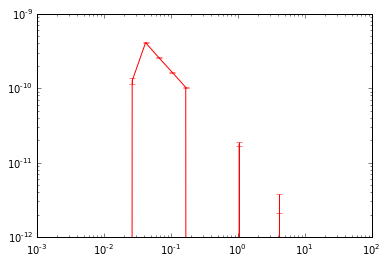

In [16]:
import treecorr
from __future__ import division
for key, grp in grouped1:
    if key == 4.5:
        cat = treecorr.Catalog(x=grp['xctr']/300,y=grp['yctr']/300,g1=np.zeros_like(grp['e1']),g2=grp['e2'])
        gg = treecorr.GGCorrelation(nbins=20,min_sep=1/300,max_sep=10000*.2/60)
        gg.process(cat)
        plt.errorbar(np.exp(gg.logr),gg.xip,np.sqrt(gg.varxi),fmt='r',label='LSST PRNU=0.4%')
        plt.yscale('log')
        plt.xscale('log')

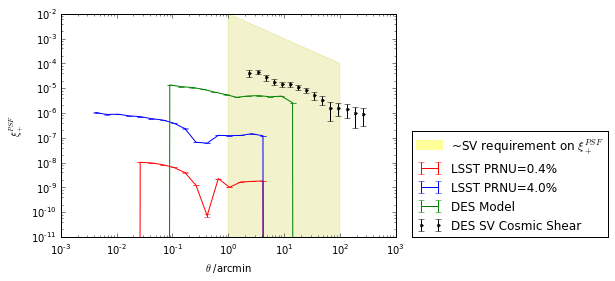

In [14]:
import treecorr
from __future__ import division
for key, grp in grouped1:
    if key == 4.5:
        cat = treecorr.Catalog(x=grp['xctr']/300,y=grp['yctr']/300,g1=grp['e1'],g2=grp['e2'])
        gg = treecorr.GGCorrelation(nbins=20,min_sep=1/300,max_sep=10000*.2/60)
        gg.process(cat)
        plt.errorbar(np.exp(gg.logr),gg.xip,np.sqrt(gg.varxi),fmt='r',label='LSST PRNU=0.4%')
for key, grp in grouped3:
    if key == 4.5:
        cat = treecorr.Catalog(x=grp['xctr']/300,y=grp['yctr']/300,g1=grp['e1'],g2=grp['e2'])
        gg = treecorr.GGCorrelation(nbins=20,min_sep=1/300,max_sep=10000*.2/60)
        gg.process(cat)
        plt.errorbar(np.exp(gg.logr),gg.xip,np.sqrt(gg.varxi),fmt='b',label='LSST PRNU=4.0%')

for key, grp in grouped4:
    if key == 4.5:
        cat = treecorr.Catalog(x=.0045*grp['xctr'],y=.0045*grp['yctr'],g1=grp['e1'],g2=grp['e2'])
        gg = treecorr.GGCorrelation(nbins=20,min_sep=.0045,max_sep=10000*.0045)
        gg.process(cat)
        plt.errorbar(np.exp(gg.logr),gg.xip,np.sqrt(gg.varxi),fmt='g',label='DES Model')

plt.errorbar(des_xip[sel,0],des_xip[sel,1],np.sqrt(err.flatten()),fmt='k.',label='DES SV Cosmic Shear')
plt.fill_between([1,100],[0,0],[1e-2,1e-4],color='y',alpha=0.2)
plt.plot([], [], color='yellow', linewidth=10,alpha=0.4,label=r'~SV requirement on $\xi_+^{PSF}$')
plt.ylabel(r'$\xi_+^{PSF}$')
plt.xlabel(r'$\theta$ /arcmin')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=(1.05,0))

(-10, 15)

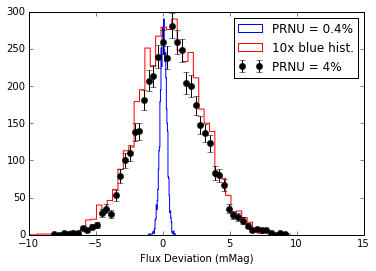

In [6]:
var = 'flux'
vec = []
for key, grp in grouped1:
    if key == 4.5:
        plt.hist(grp[var],histtype='step',bins=50,label=r'PRNU = 0.4%',color='blue')
        plt.hist(10*grp[var],histtype='step',bins=50,label='10x blue hist.',color='red')
for key, grp in grouped2:
    if key == 4.5:
        pass
        #grp[var].hist(histtype='step',bins=50,label='PRNU=0.8%',alpha=0.5)
        #counts,bin_edges = np.histogram(grp[var],bins=50)
        #bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
        #plt.errorbar(bin_centres, counts,yerr=np.sqrt(counts), fmt='ko', label='PRNU=0.8%')
for key, grp in grouped3:
    if key == 4.5:
        #pass
        x = grp[var]
        #x.hist(histtype='step',bins=50,label=r'PRNU = 4%',color='red')
        counts,bin_edges = np.histogram(grp[var],bins=50)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
        plt.errorbar(bin_centres, counts,yerr=np.sqrt(counts), fmt='ko', label=r'PRNU = 4%')

plt.legend(loc=1)
#plt.xlabel('Normalized PSF e2 Deviation')
plt.grid(False)
plt.xlabel('Flux Deviation (mMag)')
#plt.xlabel('Astrometric Deviation (mas)')
plt.xlim(-10,15)
#plt.plot(vec)

In [17]:
good_seeing = feat[np.logical_and(feat['inputPSF'] > 1.9,feat['inputPSF'] < 2.1)] 
mid_seeing = feat[np.logical_and(feat['inputPSF'] > 3.9,feat['inputPSF'] < 4.1)] 
bad_seeing = feat[np.logical_and(feat['inputPSF'] > 4.4,feat['inputPSF'] < 4.6)]
var = 'flux'
good_seeing[var].hist(label='seeing=0.4\"',histtype='step')
mid_seeing[var].hist(label='seeing=0.8\"',histtype='step')
bad_seeing[var].hist(label='seeing=1.2\"',histtype='step')
plt.title('Astrometric Errors')
plt.xlabel(r'$\Delta x$ (mas)')
plt.legend(loc=0)
print np.std(good_seeing[var]),np.std(mid_seeing[var]),np.std(bad_seeing[var]) 
print np.mean(good_seeing[var]),np.mean(mid_seeing[var]),np.mean(bad_seeing[var])

NameError: name 'feat' is not defined

In [34]:
import numpy as np
from scipy import ndimage

def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res

In [35]:
des.source.fluxes.transpose()[:-22,:-2].shape

(1700, 240)

<matplotlib.colorbar.Colorbar instance at 0x7fc005f63368>

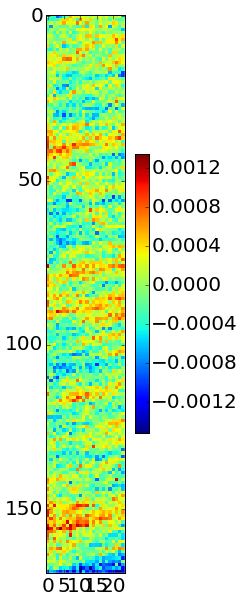

In [40]:
plt.figure(figsize=(3.5,10))
im = plt.imshow(np.flipud(block_mean(des.source.fluxes.transpose()[:-22,:-2],10))-1,interpolation='None')
plt.colorbar(shrink=.5)

In [14]:
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

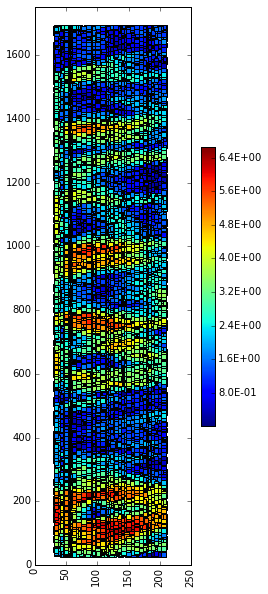

In [14]:
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
from weak_sauce.grid import MoveableGrid
#des = MoveableGrid('/nfs/slac/g/ki/ki19/des/mbaumer/ccd_mg_model_fits/des_chip04_maxit2500_step0.5_decay0.0001/mg.pkl')
des = MoveableGrid('/nfs/slac/g/ki/ki19/lsst/mbaumer/ccd_mg_model_fits/lsst_amp03_maxit100000_step0.1_decay0.0/best_mg.pkl') 

def makeSystMap(var=np.abs(feat['Mx']+1j*feat['My']),title='Astrometric shift (mas)'):
    plt.figure(figsize=(3.5, 10))
    #des.source.plot(des.source.fluxes,fig=fig,ax=axs[0])
    #im = plt.imshow(block_mean(des.source.fluxes.transpose()[:-22,:-2],10))
    #im = plt.imshow(des.source.fluxes.transpose()[0::10,0::10])
    #axs[0].set_title('Coadded flatcor')
    #plt.colorbar()
    #plt.colorbar(im,ax=axs[0],shrink=.5)
    sc = plt.scatter(feat['xctr'],feat['yctr'],c=var,marker='s')
    #plt.title(title)
    plt.ylim(0,1750)
    plt.xlim(0,250)
    plt.colorbar(shrink=.5,format='%.1E')
    plt.xticks(rotation='vertical')
    
makeSystMap()

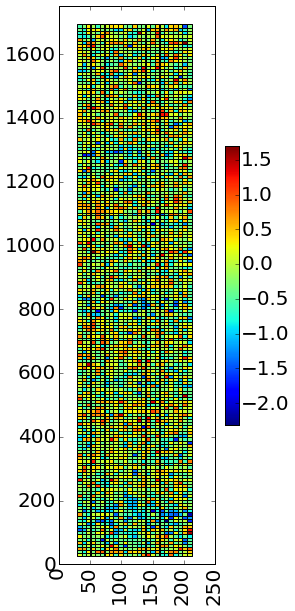

In [17]:
makeSystMap(feat['flux'],title='Flux (mMag)')

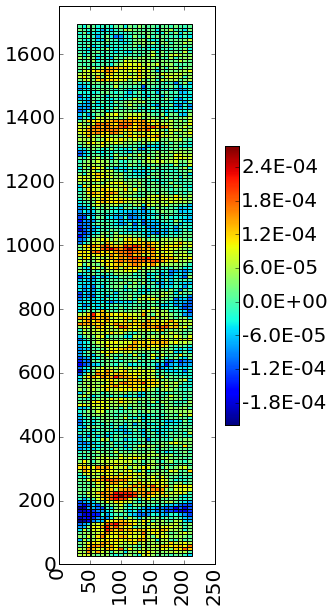

In [31]:
makeSystMap(var=feat['e1'],title='e1')

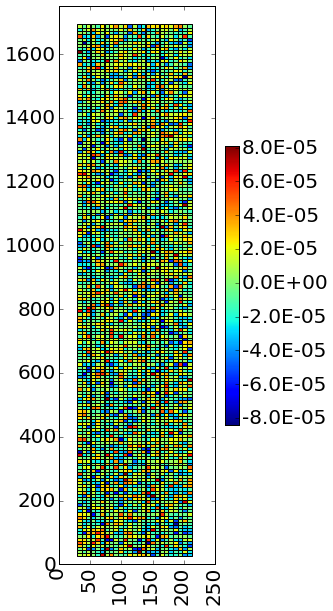

In [32]:
makeSystMap(var=feat['e2'],title='e2')

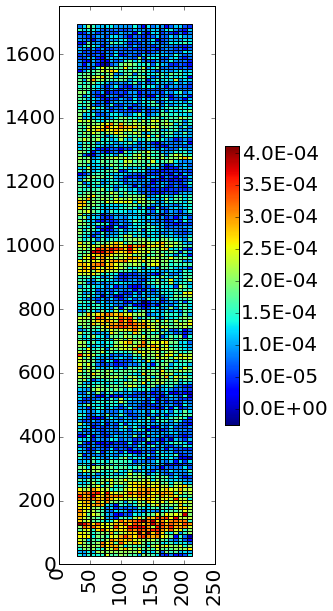

In [33]:
makeSystMap(var=feat['e0'],title='e0')

In [40]:
for var in ['Mx','My','flux','e1','e2','e0']:
    print var+' '+str(feat[var].std())

Mx 0.978589042062
My 0.615446832878
flux 0.535754731931
e1 6.53415601974e-05
e2 2.53807004554e-05
e0 7.40145178821e-05


In [42]:
for var in ['Mx','My','flux','e1','e2','e0']:
    print var+' '+str(feat[var].mean())

Mx 0.0262605583998
My 0.044553581669
flux -0.0982340918017
e1 2.87707874279e-05
e2 3.4192981731e-07
e0 0.000146961928846


In [41]:
np.abs(feat['Mx']+1j*feat['My']).mean()

1.020603426700113